<a href="https://colab.research.google.com/github/geovalexis/TFG/blob/main/notebooks/machine_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Helper functions

In [65]:
import numpy as np
import pandas as pd

def filterOutByFrequency(column: pd.Series, min_threshold: int = None, max_threshold: int = None) -> pd.Series:
    col_exploded = column.explode()
    elements_counts = col_exploded.value_counts()
    print(f"The element with the maximum number of ocurrences is {elements_counts.idxmax()} with {elements_counts.max()} ocurrences.", flush=True)
    print(f"The element with the maximum number of ocurrences is {elements_counts.idxmin()} with {elements_counts.min()} ocurrences.", flush=True)
    min_threshold = min_threshold if min_threshold else elements_counts.min()
    max_threshold = max_threshold if max_threshold else elements_counts.max()
    out_elements = elements_counts[(elements_counts<min_threshold) | (elements_counts>max_threshold)].index
    column_filtered = col_exploded[~col_exploded.isin(out_elements)].groupby(level=list(range(column.index.nlevels))).agg(list)
    return column_filtered

In [36]:
# For translating the taxIDs to their corresponding complete names

!pip install ete3
from ete3 import NCBITaxa

def getSpeciesNames(taxa: list):
    ncbi = NCBITaxa()
    tax2names = ncbi.get_taxid_translator(taxa)
    #speciesNames = [tax2names[i] for i in taxa]
    return tax2names


In [74]:
def sort_by_evolutionary_distance(reference_tax, taxa: list):
    taxa_list = taxa
    if reference_tax not in taxa_list: # The reference_tax must among the taxa list
      taxa_list.append(reference_tax)  
    ncbi = NCBITaxa()
    phylogenetic_tree = ncbi.get_topology(taxa_list)
    reference_tax_node = phylogenetic_tree.search_nodes(name=str(reference_tax))[0]
    distance_matrix = []
    for tax in taxa:
        tax_node = phylogenetic_tree.search_nodes(name=str(tax))[0]
        dist = phylogenetic_tree.get_distance(reference_tax_node, tax_node) 
        distance_matrix.append((tax_node.name, dist))
    sorted_by_dist = sorted(distance_matrix, key=lambda tup: tup[1])
    return [int(tup[0]) for tup in sorted_by_dist]

### Parse Phylogenetic Profiling Matrix (with GO terms)

In [66]:
# Read PP matrix
import pandas as pd

profiling_matrix = pd.read_table("drive/MyDrive/TFG/MtP_201601_blasted-all_proteins-pp_matrix_counts_with_taxa.tab", 
                                header=0, index_col=[0,1],  
                                converters={"GO_IDs": lambda x:  list(filter(None, x.split(",")))}) # if we don't filter there are no empty lists but lists with empty strings: [''] (its lenght is 1, not 0))
profiling_matrix

189518  ...                                             GO_IDs
9606   Q96T66       1  ...                           [GO:0009165, GO:0019674]
       Q6IQ20       1  ...  [GO:0001523, GO:0001659, GO:0048874, GO:005072...
       Q9H3J6       2  ...                                                 []
       Q14397       1  ...  [GO:0006110, GO:0006606, GO:0009750, GO:003313...
       Q8NFV4       1  ...                                                 []
...               ...  ...                                                ...
243274 Q9X0B7       0  ...                                                 []
       Q9X1T3       0  ...                                                 []
       Q9X2C2       0  ...                                                 []
       Q9X1M4       0  ...                                                 []
       Q9X043       0  ...                                                 []

[578869 rows x 79 columns]

In [67]:
# Filter out unnotated proteins
profiling_matrix = profiling_matrix[profiling_matrix["GO_IDs"].str.len()>0]  # Drop those genes that do not have GO term (the final goal of the project is to assign them one, but to train the model we need to give it resolved examples)
profiling_matrix

189518  ...                                             GO_IDs
9606   Q96T66       1  ...                           [GO:0009165, GO:0019674]
       Q6IQ20       1  ...  [GO:0001523, GO:0001659, GO:0048874, GO:005072...
       Q14397       1  ...  [GO:0006110, GO:0006606, GO:0009750, GO:003313...
       O76031       1  ...                           [GO:0046034, GO:0051603]
       P00492       1  ...  [GO:0006164, GO:0006166, GO:0006178, GO:004310...
...               ...  ...                                                ...
243274 Q9X1E4       0  ...                                       [GO:0006071]
       Q9X049       0  ...                                       [GO:0006071]
       Q9X1Z1       0  ...                                       [GO:0032218]
       P96105       0  ...                                       [GO:2000886]
       Q9X1G6       0  ...                                       [GO:0032218]

[70799 rows x 79 columns]

In [68]:
# Filter out GO terms does not meet a certain number of ocurrences
profiling_matrix = profiling_matrix.assign(GO_IDs=filterOutByFrequency(profiling_matrix["GO_IDs"], min_threshold=100, max_threshold=None))
profiling_matrix

The element with the maximum number of ocurrences is GO:0045944 with 2457 ocurrences.
The element with the maximum number of ocurrences is GO:0071951 with 1 ocurrences.


189518  85962  208964  122586  ...  224911  9606  7918        GO_IDs
9606   Q96T66       1      0       1       0  ...       0     0     0           NaN
       Q6IQ20       1      0       0       0  ...       0     0     0  [GO:0050729]
       Q14397       1      0       0       0  ...       0     0     0  [GO:0006606]
       O76031       1      1       0       0  ...       0     0     0           NaN
       P00492       1      0       1       1  ...       0     0     0  [GO:0051289]
...               ...    ...     ...     ...  ...     ...   ...   ...           ...
243274 Q9X1E4       0      0       0       0  ...       0     2     0           NaN
       Q9X049       0      0       0       0  ...       0     0     0           NaN
       Q9X1Z1       0      0       0       0  ...       0     1     0           NaN
       P96105       0      0       0       0  ...       0     0     0           NaN
       Q9X1G6       0      0       0       0  ...       0     0     0           NaN

[70799 rows x 79 columns]

# GO terms distribution

## Matrix preparation

In [81]:
GO_terms = profiling_matrix["GO_IDs"].explode()
GO_terms.index.rename(["taxID","uniprotID"], inplace=True)
GO_terms = GO_terms.reset_index()
GO_terms_distribution = GO_terms.pivot_table(values="uniprotID", index="GO_IDs", columns="taxID", aggfunc="count").fillna(0).astype(int)
GO_terms_distribution

taxID,3055,3702,4577,5664,5888,6239,6945,7070,7165,7227,7719,7739,7918,7955,8090,8364,9031,9595,9598,9606,9615,9913,10090,10116,13616,35128,36329,39947,44689,45351,64091,69014,83332,83333,85962,100226,122586,188937,189518,208964,214684,224308,224324,224911,226186,237561,237631,243230,243231,243232,243273,243274,273057,284591,284812,321614,330879,367110,436308,559292,665079,1111708
GO_IDs,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
GO:0000003,0,5,0,0,0,96,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
GO:0000045,0,2,0,1,0,5,0,0,0,7,0,0,0,5,0,2,5,0,1,30,0,7,31,13,0,0,1,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,18,0,0
GO:0000070,0,4,0,0,0,23,0,0,0,20,0,0,0,4,0,0,1,0,0,16,0,1,12,5,0,0,3,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,34,0,0,0,0,18,0,0
GO:0000082,0,3,0,0,0,2,0,0,0,7,0,0,0,3,0,0,1,0,0,78,1,6,34,17,0,0,1,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,4,0,0,0,0,22,0,0
GO:0000086,0,3,0,0,0,0,0,0,0,6,0,0,0,3,0,0,4,0,0,117,2,5,24,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,1,0,0,0,0,20,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GO:1901215,0,0,0,0,0,8,0,0,0,9,0,0,0,1,1,0,0,0,0,34,0,2,19,49,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
GO:1901796,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,125,0,0,7,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
GO:1902600,0,6,0,0,0,4,0,0,0,42,1,0,0,3,0,1,0,0,0,29,1,2,16,9,0,0,7,0,1,0,0,0,1,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,16,0,1,0,0,13,0,0


## Matrix labeling and reordering

In [82]:
# Reordered by evolutionary distance 
GO_terms_distribution = GO_terms_distribution[sort_by_evolutionary_distance(9606, list(GO_terms_distribution.columns))]

In [83]:
# Translate tax IDs to names
GO_terms_distribution = GO_terms_distribution.rename(columns=getSpeciesNames(list(GO_terms_distribution.columns)))


## Visualization

### Static Heat Map

/usr/local/lib/python3.7/dist-packages/seaborn/matrix.py:649: UserWarning:

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.



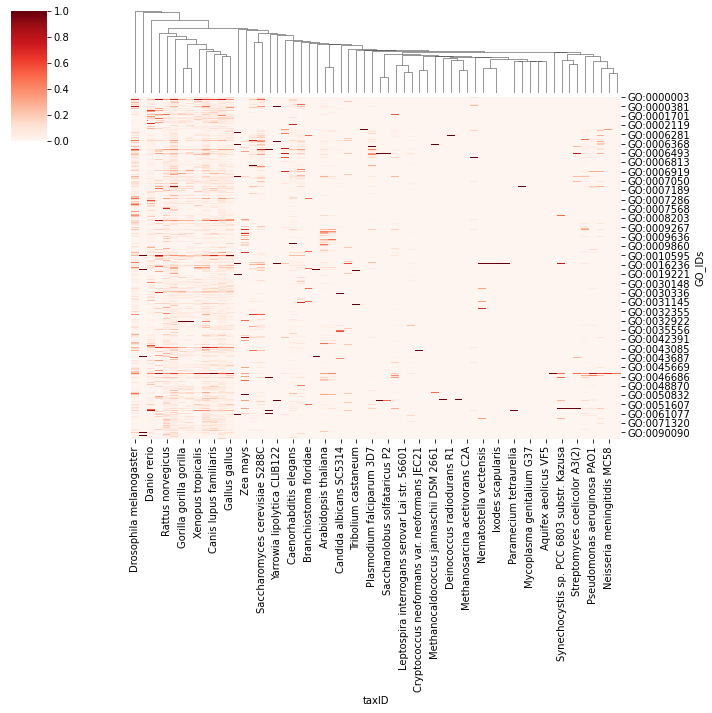

In [84]:
import seaborn as sns
import matplotlib.pyplot as plt

plot = sns.clustermap(GO_terms_distribution, 
               #method='complete', metric='hamming', 
               standard_scale=1, #figsize=(25, 10), 
               row_cluster=False, col_cluster=True, 
               cmap="Reds",        # Other way sns.mpl_palette("reds",n_colors=2, as_cmap=True))
               )
plot

### Interactive Heat Map

In [85]:
# Scaling data with sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
scaler = MinMaxScaler()
GO_terms_distribution_scaled = pd.DataFrame(scaler.fit_transform(GO_terms_distribution.values), columns=GO_terms_distribution.columns, index=GO_terms_distribution.index)
GO_terms_distribution_scaled

taxID,Homo sapiens,Gorilla gorilla gorilla,Pan troglodytes,Mus musculus,Rattus norvegicus,Canis lupus familiaris,Bos taurus,Monodelphis domestica,Gallus gallus,Xenopus tropicalis,Ciona intestinalis,Branchiostoma floridae,Lepisosteus oculatus,Danio rerio,Oryzias latipes,Caenorhabditis elegans,Nematostella vectensis,Ixodes scapularis,Leishmania major,Tribolium castaneum,Dictyostelium discoideum,Chlamydomonas reinhardtii,Anopheles gambiae,Drosophila melanogaster,Thalassiosira pseudonana,Cryptococcus neoformans var. neoformans JEC21,Ustilago maydis 521,Schizosaccharomyces pombe 972h-,Arabidopsis thaliana,Paramecium tetraurelia,Plasmodium falciparum 3D7,Leptospira interrogans serovar Lai str. 56601,Aquifex aeolicus VF5,Bacteroides thetaiotaomicron VPI-5482,Thermotoga maritima MSB8,Zea mays,Oryza sativa Japonica Group,Thermococcus kodakarensis KOD1,Neisseria meningitidis MC58,Bacillus subtilis subsp. subtilis str. 168,Bradyrhizobium diazoefficiens USDA 110,Candida albicans SC5314,Deinococcus radiodurans R1,Methanocaldococcus jannaschii DSM 2661,Mycoplasma genitalium G37,Saccharolobus solfataricus P2,Yarrowia lipolytica CLIB122,Parastagonospora nodorum SN15,Aspergillus fumigatus Af293,Nitrosopumilus maritimus SCM1,Saccharomyces cerevisiae S288C,Synechocystis sp. PCC 6803 substr. Kazusa,Halobacterium salinarum NRC-1,Mycobacterium tuberculosis H37Rv,Escherichia coli K-12,Helicobacter pylori 26695,Streptomyces coelicolor A3(2),Methanosarcina acetivorans C2A,Pseudomonas aeruginosa PAO1,Geobacter sulfurreducens PCA,Neurospora crassa OR74A,Sclerotinia sclerotiorum 1980 UF-70
GO_IDs,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
GO:0000003,0.001325,0.0,0.00,0.001364,0.004706,0.000000,0.000000,0.0,0.032258,0.000000,0.0,0.0,0.0,0.006452,0.0,0.347826,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.005051,0.0,0.0,0.0,0.000000,0.008576,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GO:0000045,0.039735,0.0,0.05,0.042292,0.030588,0.000000,0.112903,0.0,0.161290,0.095238,0.0,0.0,0.0,0.032258,0.0,0.018116,0.0,0.0,0.083333,0.0,0.03125,0.0,0.0,0.035354,0.0,0.0,0.0,0.008621,0.003431,0.0,0.010989,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.102857,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GO:0000070,0.021192,0.0,0.00,0.016371,0.011765,0.000000,0.016129,0.0,0.032258,0.000000,0.0,0.0,0.0,0.025806,0.0,0.083333,0.0,0.0,0.000000,0.0,0.01250,0.0,0.0,0.101010,0.0,0.0,0.0,0.293103,0.006861,0.0,0.032967,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.013624,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.102857,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GO:0000082,0.103311,0.0,0.00,0.046385,0.040000,0.043478,0.096774,0.0,0.032258,0.000000,0.0,0.0,0.0,0.019355,0.0,0.007246,0.0,0.0,0.000000,0.0,0.01250,0.0,0.0,0.035354,0.0,0.0,0.0,0.034483,0.005146,0.0,0.010989,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.010899,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.125714,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GO:0000086,0.154967,0.0,0.00,0.032742,0.023529,0.086957,0.080645,0.0,0.129032,0.000000,0.0,0.0,0.0,0.019355,0.0,0.000000,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.030303,0.0,0.0,0.0,0.008621,0.005146,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.008174,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.114286,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GO:1901215,0.045033,0.0,0.00,0.025921,0.115294,0.000000,0.032258,0.0,0.000000,0.000000,0.0,0.0,0.0,0.006452,1.0,0.028986,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.045455,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.000

In [86]:
import plotly.graph_objects as go

fig = go.Figure(data=go.Heatmap(
                   z=GO_terms_distribution_scaled.values,
                   x=GO_terms_distribution_scaled.columns,
                   y=GO_terms_distribution_scaled.index,
                   hoverongaps = False,
                   colorscale='Reds',
                   colorbar= dict(title="Intensity")
                   ))
fig.update_layout(
    title='Go terms distribution',
)
fig.update_yaxes(title="GO terms")
fig.update_xaxes(type='category', title="Species")
fig.show()


# Machine Learning

## With single classification models

When a gene has several GO terms, they are reduced to just one: the Lowest Common Ancestor (LCA). 

## With multi-label (various GO terms) classification models

## Prepare training dataset

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer

training_matrix = profiling_matrix[profiling_matrix["GO_IDs"].str.len()>0]  # Filter out some proteins that may have remained without any annotation after passing through the ocurrences filter.

X_training_matrix = training_matrix.iloc[:, :-1]
y_training_matrix = training_matrix.iloc[:, -1:] # The last column corresponds to the GO_IDs

# We need to compute one-hot encoding for multilable classification as the models does not accept matrices with different shape.
mlb = MultiLabelBinarizer()
y_training_matrix_encoded = pd.DataFrame(mlb.fit_transform(y_training_matrix["GO_IDs"]), columns=mlb.classes_, index=y_training_matrix.index)

y_training_matrix_encoded

,GO:0000086,GO:0000122,GO:0000165,GO:0000184,GO:0000209,GO:0000398,GO:0001934,GO:0002223,GO:0002576,GO:0006281,...,GO:0055114,GO:0060271,GO:0061024,GO:0065003,GO:0070268,GO:0070374,GO:0072659,GO:0090090,GO:0090263,GO:1901796
Q13751,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
P51160,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
P35913,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
O00408,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Q9HCR9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
P01714,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Q05315,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Q3LHN2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Q701N2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Model selection

In [ ]:
# Support multilabel by default
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

# Does not support multilabel but multiclass does
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
#from sklearn.linear_model import RidgeClassifierCV
from sklearn.naive_bayes import MultinomialNB

from sklearn.multiclass import OneVsRestClassifier
from sklearn.multioutput import ClassifierChain
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_validate


In [ ]:
# Simple method (without cross-validation)
X_train, X_test, y_train, y_test = train_test_split(X_training_matrix, y_training_matrix_encoded, test_size=0.25)
model = RandomForestClassifier().fit(X_train, y_train)
y_test_predictions = model.predict(X_test)
accuracy_score(y_test, y_test_predictions)

0.03076923076923077

In [ ]:
# With cross-validation
model = RandomForestClassifier().fit(X_training_matrix, y_training_matrix_encoded)
cross_validate(model, X_train, y_train, cv=5, scoring=("accuracy", "f1_macro"), n_jobs=-1) # We could also choose only one scoring method

{'fit_time': array([6.23813462, 6.21307921, 6.28599119, 6.15516257, 5.2181108 ]),
 'score_time': array([0.64078617, 0.64489555, 0.61125302, 0.61550689, 0.52815628]),
 'test_accuracy': array([0.03247863, 0.03162393, 0.02735043, 0.03333333, 0.03678358]),
 'test_f1_macro': array([0.11274907, 0.10547702, 0.12313474, 0.09820239, 0.08827066])}

In [ ]:
# From https://towardsdatascience.com/simple-way-to-find-a-suitable-algorithm-for-your-data-in-scikit-learn-python-9a9710c7c0fe

def create_baseline_classifiers(seed=8):
    """Create a list of baseline classifiers.
    
    Parameters
    ----------
    seed: (optional) An integer to set seed for reproducibility
    Returns
    -------
    A list containing tuple of model's name and object.
    """
    models = {}
    # Inherently multilabel
    models['Dummy'] = DummyClassifier(random_state=seed, strategy='prior')
    models['RandomForest'] = RandomForestClassifier(random_state=seed, n_jobs=1) # Random Forest consumes a lot of memory to be run in parallel
    models['KNN'] = KNeighborsClassifier(n_jobs=1)
    models['NeuralNetwork'] = MLPClassifier(random_state=seed)

    # No support for multilabel unless using OneVSRestClassifier or ClassifierChain
    models['SupportVectorMachine'] = OneVsRestClassifier(SVC(random_state=seed, probability=True), n_jobs=1)
    models['GradientBoosting'] = OneVsRestClassifier(GradientBoostingClassifier(random_state=seed), n_jobs=1)
    models['MultinomialNB'] = OneVsRestClassifier(MultinomialNB(), n_jobs=1)
    return models

def assess_models(X, y, models, cv=5, metrics=('accuracy','roc_auc', 'f1')):
    """Provide summary of cross validation results for models.
    
    Parameters
    ----------
    X: A pandas DataFrame containing feature matrix
    y: A pandas Series containing target vector
    models: A list of models to train
    cv: (optional) An integer to set number of folds in cross-validation
    metrics: (optional) A list of scoring metrics or a string for a metric
    Returns
    -------
    A pandas DataFrame containing summary of baseline models' performance.
    
    """
    summary = pd.DataFrame()
    for name, model in models.items():
        result = pd.DataFrame(cross_validate(model, X, y, cv=cv, scoring=metrics, n_jobs=-1))
        mean = result.mean().rename('{}_mean'.format)
        std = result.std().rename('{}_std'.format)
        summary[name] = pd.concat([mean, std], axis=0)
    return summary.sort_index()

### Models training

In [ ]:
models = create_baseline_classifiers()
summary = assess_models(X_train, y_train, models, metrics=("accuracy", "f1_macro"))
summary

,Dummy,RandomForest,KNN,NeuralNetwork,SupportVectorMachine,GradientBoosting,MultinomialNB
fit_time_mean,0.012070,6.066271,0.049460,9.410647,218.109081,59.386899,0.332783
fit_time_std,0.000399,0.467689,0.000491,1.205765,26.750227,3.315319,0.034970
score_time_mean,0.011875,0.613065,2.749094,0.017109,6.199454,0.256870,0.180541
score_time_std,0.000880,0.055037,0.228358,0.001353,0.242055,0.018800,0.013614
test_accuracy_mean,0.000000,0.032314,0.038468,0.033168,0.012139,0.035391,0.008206
test_accuracy_std,0.000000,0.002299,0.003578,0.007314,0.003795,0.003504,0.002057
test_f1_macro_mean,0.000000,0.106273,0.106140,0.112676,0.022425,0.131963,0.096278
test_f1_macro_std,0.000000,0.014950,0.014010,0.011316,0.003732,0.007767,0.004421


In [ ]:
summary.to_csv("results/MTP/MtP_201601_blasted-ML_asessment.tab")

# Deprecated cells

In [ ]:
# Wrong way of performing one hot encoding 
import pandas
y_training_matrix_one_hot_encoded = pd.get_dummies(y_training_matrix["GO_IDs"].explode(), 
                                                   prefix="", prefix_sep=""
                                                   ).reset_index().groupby("index").first() # We take the first ocurrence as they all must be the same (no matter the first, last or whatever)


In [ ]:
# 1st version of the PP matrix (without GO terms)
# We need to assign GO terms to profiling matrix
import json
import pandas as pd
profiling_matrix = getOrthologsPresenceMatrix()
with open("drive/MyDrive/TFG/human_genes2GOtermIDs.json", "r") as input:
    human_gene2GOterms = json.load(input)
profiling_matrix["GO_IDs"] = profiling_matrix.index.map(lambda x: np.array(human_gene2GOterms.get(x)) if human_gene2GOterms.get(x) else [])